In [1]:
import argparse
from pathlib import Path
import csv
from tqdm import tqdm
from datetime import datetime

import pandas as pd
from allennlp.data.vocabulary import Vocabulary
from allennlp.common.util import dump_metrics

from adat.dataset import ClassificationReader, CopyNetReader, IDENTITY_TOKEN
from adat.attackers.mcmc import MCMCSampler, RandomSampler, NormalProposal, AttackerOutput
from adat.models import get_model_by_name
from adat.utils import load_weights, get_args_from_path

In [52]:
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--cuda', type=int, default=-1)
parser.add_argument('--csv_path', type=str, default='data/test.csv')
parser.add_argument('--results_path', type=str, default='results')
parser.add_argument('--classifier_path', type=str, default='experiments/classification')
parser.add_argument('--copynet_path', type=str, default='experiments/copynet')
parser.add_argument('--maskers', type=str, default=IDENTITY_TOKEN, help='string with comma-separated values')
parser.add_argument('--num_steps', type=int, default=100)
parser.add_argument('--beam_size', type=int, default=1)
parser.add_argument('--std', type=float, default=0.01)
parser.add_argument('--sigma_class', type=float, default=1.0)
parser.add_argument('--sigma_wer', type=float, default=0.5)
parser.add_argument('--random', action='store_true', help='Whether to use RandomSampler instead of MCMC')
parser.add_argument('--early_stopping', action='store_true')
parser.add_argument('--sample', type=int, default=None)

_StoreAction(option_strings=['--sample'], dest='sample', nargs=None, const=None, default=None, type=<class 'int'>, choices=None, help=None, metavar=None)

In [3]:
args = parser.parse_args(args=[])

In [4]:
args.csv_path = 'data/ag_news_mini/test.csv'
args.results_path = 'results/ag_news_mini/random'
args.classifier_path = 'experiments/ag_news_mini/classification'
args.copynet_path = 'experiments/ag_news_mini/nonmasked_copynet_with_attention'
args.beam_size = 3
args.cuda = 0
args.sample = 100

In [5]:
class_reader = ClassificationReader(skip_start_end=True)
class_vocab = Vocabulary.from_files(Path(args.classifier_path) / 'vocab')
class_model_args = get_args_from_path(Path(args.classifier_path) / 'args.json')
class_model = get_model_by_name(**class_model_args, vocab=class_vocab)
load_weights(class_model, Path(args.classifier_path) / 'best.th')

copynet_reader = CopyNetReader(masker=None)
copynet_vocab = Vocabulary.from_files(Path(args.copynet_path) / 'vocab')
copynet_model_args = get_args_from_path(Path(args.copynet_path) / 'args.json')
copynet_model = get_model_by_name(**copynet_model_args, vocab=copynet_vocab, beam_size=args.beam_size)
load_weights(copynet_model, Path(args.copynet_path) / 'best.th')


In [6]:
if args.random:
    print('RANDOM!')
    sampler = RandomSampler(
        proposal_distribution=NormalProposal(scale=args.std),
        classification_model=class_model,
        classification_reader=class_reader,
        generation_model=copynet_model,
        generation_reader=copynet_reader,
        device=args.cuda
    )
else:
    sampler = MCMCSampler(
        proposal_distribution=NormalProposal(scale=args.std),
        classification_model=class_model,
        classification_reader=class_reader,
        generation_model=copynet_model,
        generation_reader=copynet_reader,
        sigma_class=args.sigma_class,
        sigma_wer=args.sigma_wer,
        device=args.cuda
    )

In [7]:
data = pd.read_csv(args.csv_path)
sequences = data['sequences'].tolist()[:args.sample]
labels = data['labels'].tolist()[:args.sample]
maskers = [args.maskers.split(',')] * len(sequences)  # can be unique for each sequence



In [16]:
sampler.empty_history()


In [21]:
fieldnames = list(AttackerOutput.__annotations__.keys())
hiddens = []
for i, (seq, lab, mask) in tqdm(enumerate(zip(sequences, labels, maskers))):
    sampler.set_label_to_attack(lab)
    sampler.set_input(seq, mask_tokens=mask)
    output = sampler.sample_until_label_is_changed(
        max_steps=args.num_steps,
        early_stopping=args.early_stopping
    ).__dict__
    hiddens.append(sampler.current_state['decoder_hidden'])
    
    sampler.empty_history()

    if i > 100:
        break

100it [01:03,  1.56it/s]


In [47]:
sampler.empty_history()

In [48]:
sampler.set_label_to_attack(lab)

In [49]:
seq

' iran flipflopping on nuclear agreement'

In [53]:
mask_tokens = mask

In [54]:
sampler.initial_sequence = seq
with torch.no_grad():
    inputs = sampler._seq_to_input(
        sampler.initial_sequence,
        sampler.generation_reader,
        sampler.generation_vocab,
        mask_tokens=mask_tokens
    )

In [55]:
inputs

{'tokens': {'tokens': tensor([[23507,    80, 13758,     5,   148,   924, 23508]], device='cuda:0')},
 'target_tokens': {'tokens': tensor([[23507,    80, 13758,     5,   148,   924, 23508]], device='cuda:0')},
 'source_tokens': {'tokens': tensor([[23507,    80, 13758,     5,   148,   924, 23508]], device='cuda:0')},
 'mask_tokens': {'tokens': tensor([[2]], device='cuda:0')}}

In [ ]:
    sampler.current_state = self.generation_model.encode(
        source_tokens=inputs['source_tokens'],
        mask_tokens=inputs['mask_tokens']
    )

In [42]:
sampler.set_label_to_attack(lab)
sampler.set_input(seq, mask_tokens=mask)
output = sampler.sample_until_label_is_changed(
    max_steps=args.num_steps,
    early_stopping=args.early_stopping
).__dict__

In [43]:
sampler.current_state

{'source_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='cuda:0'),
 'encoder_outputs': tensor([[[ 0.0951, -0.0725,  0.0319,  0.0809, -0.1044,  0.1006,  0.1356,
           -0.0759, -0.0908, -0.0458, -0.1162,  0.0530, -0.0378, -0.0856,
            0.1034, -0.0329,  0.1315, -0.0499,  0.0448, -0.0887,  0.0604,
           -0.0190,  0.0334,  0.1297, -0.0643,  0.0737, -0.0725,  0.1221,
            0.1606, -0.1076,  0.0805,  0.0400,  0.8947, -0.8190,  0.8089,
            0.7769, -0.8673,  0.9125, -0.7985, -0.9300,  0.9054, -0.8909,
           -0.8689,  0.9328, -0.9105,  0.2450, -0.8510, -0.3008, -0.6697,
           -0.7879,  0.4915, -0.8232, -0.8093,  0.9056, -0.6258, -0.8208,
           -0.8679, -0.8374, -0.8813, -0.6819, -0.7893, -0.7285,  0.4460,
           -0.9072],
          [ 0.1801, -0.2066, -0.0625,  0.1841, -0.2024,  0.1981,  0.2907,
           -0.1602, -0.1812, -0.0753, -0.2950, -0.0031, -0.1075, -0.1624,
            0.2269, -0.0695,  0.2535, -0.1253,  0.1458, -0.2051,  0.2121,
      

In [34]:
X = torch.stack(hiddens).squeeze().cpu().data.numpy()

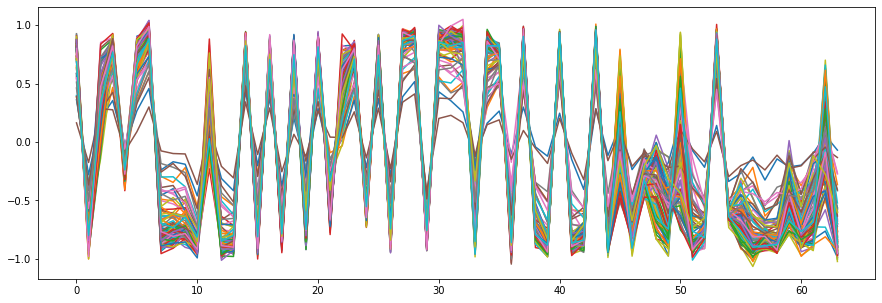

In [38]:
plt.figure(figsize=(15, 5))
plt.plot(X.T);